Number of images in 'first print': 100
Number of images in 'second print': 100


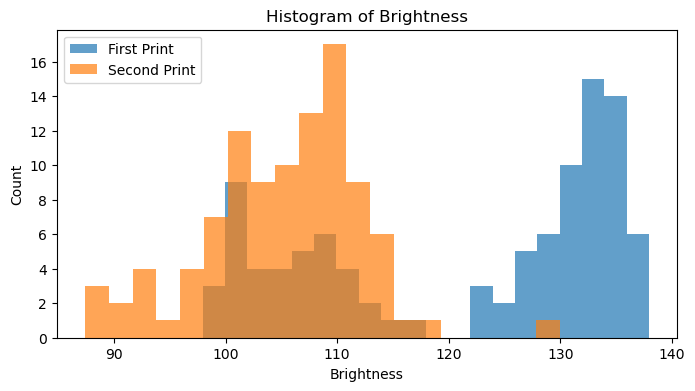

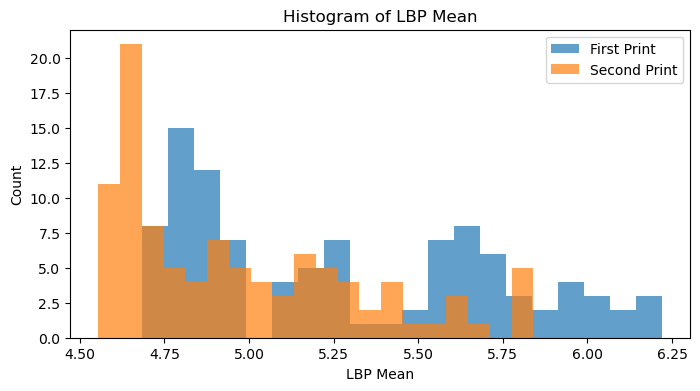

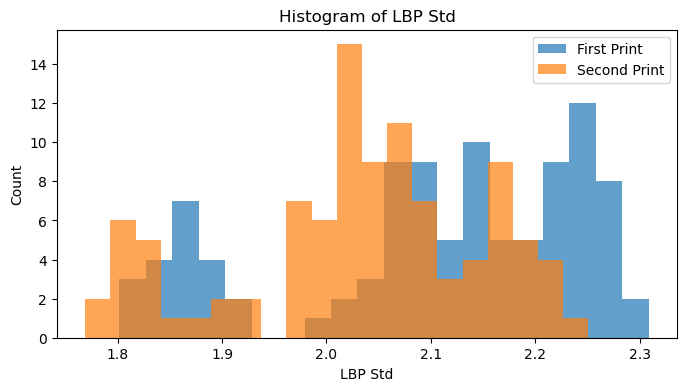

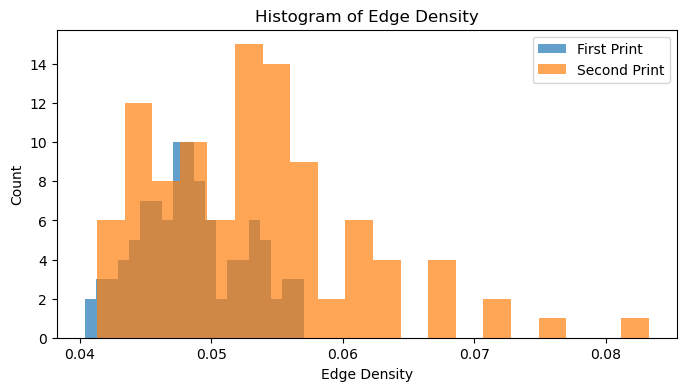

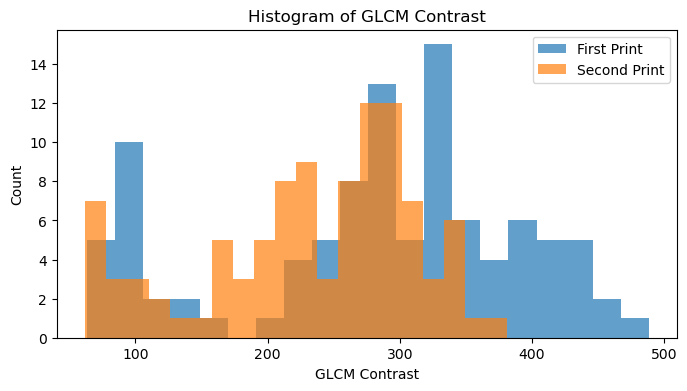

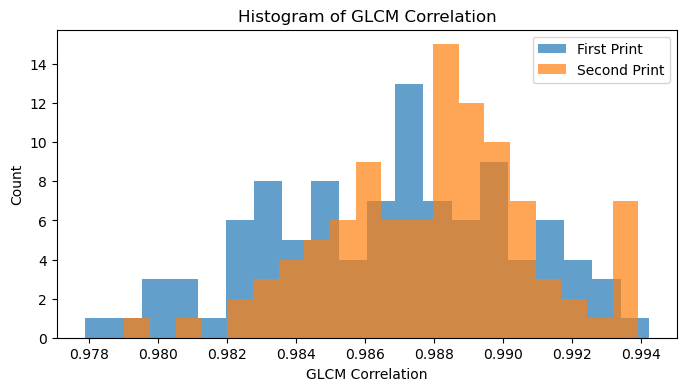

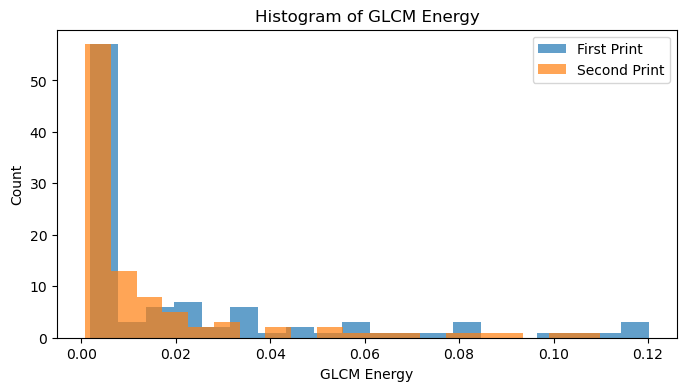

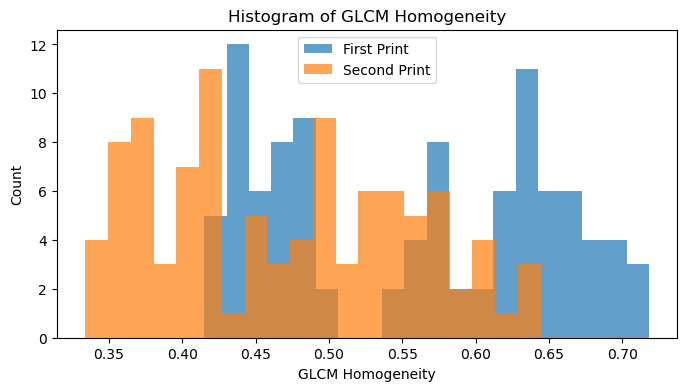

In [1]:
# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

# Set up directories for the two classes (first print and second print)
first_print_dir = "first print"
second_print_dir = "second print"

# Function to list image files (only .png) in a given folder
def list_images(folder):
    valid_extensions = (".png",)
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]

# Get the list of image paths for both classes
images_first = list_images(first_print_dir)
images_second = list_images(second_print_dir)

# Print out how many images are found in each class
print(f"Number of images in 'first print': {len(images_first)}")
print(f"Number of images in 'second print': {len(images_second)}")

# -----------------------------
# Feature Extraction Functions
# -----------------------------

# Calculate the average brightness (mean pixel intensity) of an image.
def compute_brightness(image):
    return np.mean(image)

# Calculate the Local Binary Pattern (LBP) for the image, then return the LBP image along with its mean and standard deviation.
def compute_lbp(image, radius=1, n_points=8):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp, np.mean(lbp), np.std(lbp)

# Calculate the edge density using Canny edge detection.
# Edge density is the ratio of the number of edge pixels to the total number of pixels.
def compute_edge_density(image):
    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    edge_pixels = np.sum(edges > 0)
    total_pixels = image.shape[0] * image.shape[1]
    return edge_pixels / total_pixels

# Compute GLCM (Gray-Level Co-occurrence Matrix) texture features for horizontal neighboring pixels.
# The function returns contrast, correlation, energy, and homogeneity.
def compute_glcm_features(image):
    img = image.astype(np.uint8)
    rows, cols = img.shape
    # Create a 256x256 matrix to count the occurrence of pixel pairs (assumes pixel values in [0, 255])
    glcm = np.zeros((256, 256), dtype=np.float64)
    
    # Loop over the image and count the co-occurrence of pixel values for horizontal neighbors.
    for i in range(rows):
        for j in range(cols - 1):
            current = img[i, j]
            neighbor = img[i, j+1]
            glcm[current, neighbor] += 1
    
    # Normalize the GLCM so that the values represent probabilities.
    glcm_sum = glcm.sum()
    if glcm_sum != 0:
        glcm = glcm / glcm_sum
    
    # Create index arrays for each element in the GLCM
    i_indices, j_indices = np.indices(glcm.shape)
    
    # Calculate contrast: a measure of intensity contrast between a pixel and its neighbor.
    contrast = np.sum(glcm * (i_indices - j_indices)**2)
    
    # Calculate means for the GLCM indices.
    mean_i = np.sum(i_indices * glcm)
    mean_j = np.sum(j_indices * glcm)
    
    # Calculate standard deviations for the GLCM indices.
    std_i = np.sqrt(np.sum(((i_indices - mean_i)**2) * glcm))
    std_j = np.sqrt(np.sum(((j_indices - mean_j)**2) * glcm))
    
    # Calculate correlation: how correlated a pixel is to its neighbor.
    if std_i * std_j == 0:
        correlation = 0
    else:
        correlation = np.sum((i_indices - mean_i) * (j_indices - mean_j) * glcm) / (std_i * std_j)
    
    # Calculate energy: the sum of squared elements in the GLCM, representing textural uniformity.
    energy = np.sum(glcm**2)
    
    # Calculate homogeneity: measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.
    homogeneity = np.sum(glcm / (1.0 + np.abs(i_indices - j_indices)))
    
    return contrast, correlation, energy, homogeneity

# -----------------------------
# Master Feature Extraction
# -----------------------------

# This function loads an image (in grayscale), computes all desired features, and returns them.
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error loading image: {image_path}")
        # Return default zero values if image can't be loaded
        return 0, 0, 0, 0, (0, 0, 0, 0)
    
    brightness = compute_brightness(img)
    lbp_img, lbp_mean, lbp_std = compute_lbp(img)
    edge_density = compute_edge_density(img)
    glcm_feats = compute_glcm_features(img)  # Returns contrast, correlation, energy, homogeneity
    
    return brightness, lbp_mean, lbp_std, edge_density, glcm_feats

# Extract features for all images in each category
features_first = [extract_features(path) for path in images_first]
features_second = [extract_features(path) for path in images_second]

# -----------------------------
# Convert and Organize the Features
# -----------------------------

# This helper function flattens the extracted features into a single NumPy array per image.
# The feature vector will contain: brightness, lbp_mean, lbp_std, edge_density, contrast, correlation, energy, homogeneity.
def flatten_features(feature_list):
    flattened = []
    for f in feature_list:
        brightness, lbp_mean, lbp_std, edge_density, glcm_feats = f
        contrast, correlation, energy, homogeneity = glcm_feats
        flattened.append([brightness, lbp_mean, lbp_std, edge_density, contrast, correlation, energy, homogeneity])
    return np.array(flattened)

features_first = flatten_features(features_first)
features_second = flatten_features(features_second)

# Define human-readable names for each feature (useful for plotting and interpretation)
feature_names = [
    "Brightness", "LBP Mean", "LBP Std", "Edge Density",
    "GLCM Contrast", "GLCM Correlation", "GLCM Energy", "GLCM Homogeneity"
]

# -----------------------------
# Visualize Feature Distributions
# -----------------------------

# This function plots histograms comparing a particular feature between first and second prints.
def plot_feature_histograms(feature_index, feature_name):
    plt.figure(figsize=(8, 4))
    plt.hist(features_first[:, feature_index], bins=20, alpha=0.7, label="First Print")
    plt.hist(features_second[:, feature_index], bins=20, alpha=0.7, label="Second Print")
    plt.title(f"Histogram of {feature_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# Loop through each feature and plot its histogram.
for i, name in enumerate(feature_names):
    plot_feature_histograms(i, name)


In [2]:
# =============================
# Feature Engineering for QR Code Authentication
# =============================

# Import required libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.feature import local_binary_pattern

# ---------- 1. Setup Directories ----------
# Define the paths to the folders containing the original (first print) and counterfeit (second print) QR code images.
first_print_dir = "first print"
second_print_dir = "second print"

# A helper function to list all image files in a folder. Here we consider common image extensions.
def list_images(folder):
    valid_extensions = (".png", ".jpg", ".jpeg")
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(valid_extensions)]

# Get the image file paths for both classes.
images_first = list_images(first_print_dir)
images_second = list_images(second_print_dir)

# Print out the number of images in each class to confirm the dataset composition.
print(f"Number of images in 'first print': {len(images_first)}")
print(f"Number of images in 'second print': {len(images_second)}")

# ---------- 2. Define Feature Extraction Functions ----------
# In this section, we define functions to extract various features from an image.
# These features include global properties (like brightness and sharpness) and local texture patterns (using LBP and GLCM).

# Compute the average brightness of an image (mean pixel intensity).
def compute_brightness(image):
    """Calculate and return the average brightness of the image."""
    return float(np.mean(image))

# Compute the image sharpness using the variance of the Laplacian.
def compute_sharpness(image):
    """
    Calculate the sharpness of the image.
    We use the variance of the Laplacian operator; a higher value indicates a sharper image.
    """
    return float(cv2.Laplacian(image, cv2.CV_64F).var())

# Compute the edge density using Canny edge detection.
def compute_edge_density(image):
    """
    Determine the edge density of the image.
    This function uses Canny edge detection to count the number of edge pixels
    and divides by the total number of pixels, which can help indicate print artifacts.
    """
    edges = cv2.Canny(image, 100, 200)
    edge_pixels = np.sum(edges > 0)
    total_pixels = image.shape[0] * image.shape[1]
    return edge_pixels / total_pixels if total_pixels > 0 else 0

# Compute Local Binary Pattern (LBP) for capturing texture.
def compute_lbp(image, radius=1, n_points=8):
    """
    Compute the Local Binary Pattern (LBP) of an image.
    Returns the LBP image along with its mean and standard deviation,
    which are useful as texture descriptors.
    """
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    return lbp, float(lbp.mean()), float(lbp.std())

# Compute Gray-Level Co-occurrence Matrix (GLCM) texture features.
def compute_glcm_features(image):
    """
    Calculate GLCM-based features for the image, considering only horizontal neighbors (angle=0, distance=1).
    Returns a tuple with contrast, correlation, energy, and homogeneity.
    """
    img = image.astype(np.uint8)
    rows, cols = img.shape
    # Initialize a 256x256 matrix to store the frequency of co-occurring pixel values.
    glcm = np.zeros((256, 256), dtype=np.float64)
    
    # Iterate through the image to fill the GLCM for horizontal neighbor pairs.
    for i in range(rows):
        for j in range(cols - 1):
            current = img[i, j]
            neighbor = img[i, j+1]
            glcm[current, neighbor] += 1

    # Normalize the GLCM to convert counts to probabilities.
    glcm_sum = glcm.sum()
    if glcm_sum > 0:
        glcm = glcm / glcm_sum

    # Create index arrays corresponding to each cell in the GLCM.
    i_indices, j_indices = np.indices(glcm.shape)
    
    # Calculate contrast: weighted sum of squared differences between pixel pairs.
    contrast = np.sum(glcm * (i_indices - j_indices)**2)
    
    # Calculate means of the indices.
    mean_i = np.sum(i_indices * glcm)
    mean_j = np.sum(j_indices * glcm)
    
    # Calculate standard deviations of the indices.
    std_i = np.sqrt(np.sum(((i_indices - mean_i)**2) * glcm))
    std_j = np.sqrt(np.sum(((j_indices - mean_j)**2) * glcm))
    
    # Calculate correlation: measure of how correlated a pixel is with its neighbor.
    if std_i * std_j == 0:
        correlation = 0
    else:
        correlation = np.sum((i_indices - mean_i) * (j_indices - mean_j) * glcm) / (std_i * std_j)
    
    # Calculate energy: sum of squared elements of the GLCM, indicating textural uniformity.
    energy = np.sum(glcm**2)
    
    # Calculate homogeneity: measures the closeness of the distribution of elements to the diagonal.
    homogeneity = np.sum(glcm / (1.0 + np.abs(i_indices - j_indices)))
    
    return float(contrast), float(correlation), float(energy), float(homogeneity)

# Compute the number of SIFT keypoints in the image.
def compute_sift_keypoints(image):
    """
    Count the number of SIFT keypoints in the image.
    A higher or lower count may indicate differences in print quality or CDP degradation.
    (Note: Requires opencv-contrib-python to be installed.)
    """
    sift = cv2.SIFT_create()
    keypoints, _ = sift.detectAndCompute(image, None)
    return len(keypoints) if keypoints is not None else 0

# ---------- 3. Master Feature Extraction Function ----------
# This function loads an image in grayscale and extracts all the defined features,
# then returns them in a dictionary.
def extract_features(image_path):
    """
    Load the image (in grayscale) and extract a comprehensive set of features.
    Returns a dictionary containing global features (brightness, sharpness, edge density),
    local texture features (LBP statistics, GLCM properties),
    and SIFT keypoint count.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None  # If the image can't be loaded, return None.
    
    features = {}
    # Extract global features
    features["brightness"] = compute_brightness(img)
    features["sharpness"] = compute_sharpness(img)
    features["edge_density"] = compute_edge_density(img)
    
    # Extract local texture features using LBP
    _, lbp_mean, lbp_std = compute_lbp(img)
    features["lbp_mean"] = lbp_mean
    features["lbp_std"] = lbp_std
    
    # Extract GLCM features
    contrast, correlation, energy, homogeneity = compute_glcm_features(img)
    features["glcm_contrast"] = contrast
    features["glcm_correlation"] = correlation
    features["glcm_energy"] = energy
    features["glcm_homogeneity"] = homogeneity
    
    # Extract SIFT keypoints count
    features["sift_keypoints"] = compute_sift_keypoints(img)
    
    return features

# ---------- 4. Apply Feature Extraction on the Dataset ----------
# Loop through all images for each class, extract their features, and assign a label (0 for first print, 1 for second print).
features_list = []
labels_list = []  # 0 for first print, 1 for second print

# Process images from the "first print" folder.
for path in images_first:
    feats = extract_features(path)
    if feats is not None:
        features_list.append(feats)
        labels_list.append(0)

# Process images from the "second print" folder.
for path in images_second:
    feats = extract_features(path)
    if feats is not None:
        features_list.append(feats)
        labels_list.append(1)

# ---------- 5. Convert Features to a DataFrame and Report Statistics ----------
# Convert the list of feature dictionaries into a Pandas DataFrame.
df_features = pd.DataFrame(features_list)
# Add the label column to the DataFrame.
df_features["label"] = labels_list

# Show a preview of the DataFrame to check the extracted features.
print("\nFeature DataFrame Preview:")
print(df_features.head())

# Display summary statistics for each feature grouped by class.
print("\nSummary Statistics by Class:")
print(df_features.groupby("label").describe())

# Optionally, save the engineered feature set to a CSV file for later analysis or modeling.
df_features.to_csv("qr_features_engineered.csv", index=False)
print("\nFeature set saved to 'qr_features_engineered.csv'.")


Number of images in 'first print': 100
Number of images in 'second print': 100

Feature DataFrame Preview:
   brightness   sharpness  edge_density  lbp_mean   lbp_std  glcm_contrast  \
0   98.477146  344.045673      0.047189  4.968033  2.144955     280.213844   
1  128.911892  666.646374      0.053447  6.100527  2.235667     465.242560   
2  129.975509  261.031433      0.045536  5.612583  2.179184     254.967548   
3  128.993593  517.166254      0.048594  5.271350  2.164420     400.537815   
4  102.561000   85.267234      0.048701  4.843659  1.869854      95.994124   

   glcm_correlation  glcm_energy  glcm_homogeneity  sift_keypoints  label  
0          0.983936     0.004070          0.488989            2221      0  
1          0.982470     0.119003          0.689307            1720      0  
2          0.989792     0.023210          0.634396            1615      0  
3          0.984301     0.005408          0.579009            1928      0  
4          0.991385     0.003268          0.

In [8]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Loading the CSV file that contains the engineered features for QR code classification
df_features = pd.read_csv("qr_features_engineered.csv")

# Separating data based on labels: 
# 'First Print' (Original QR Codes) → label = 0
# 'Second Print' (Fake QR Codes) → label = 1
df_first_print = df_features[df_features["label"] == 0]  # Extracting all original QR codes
df_second_print = df_features[df_features["label"] == 1]  # Extracting all fake QR codes

# Splitting both classes into 70% training and 30% testing to maintain balance
df_first_train, df_first_test = train_test_split(df_first_print, test_size=0.3, random_state=42)
df_second_train, df_second_test = train_test_split(df_second_print, test_size=0.3, random_state=42)

# Combining training sets: 70% of 'First Print' + 70% of 'Second Print'
X_train = pd.concat([df_first_train.drop("label", axis=1), df_second_train.drop("label", axis=1)]).values
y_train = pd.concat([df_first_train["label"], df_second_train["label"]]).values

# Combining testing sets: 30% of 'First Print' + 30% of 'Second Print'
X_test = pd.concat([df_first_test.drop("label", axis=1), df_second_test.drop("label", axis=1)]).values
y_test = pd.concat([df_first_test["label"], df_second_test["label"]]).values

# Initializing a Support Vector Machine (SVM) classifier with a linear kernel
svm_clf = SVC(kernel="linear", random_state=42)

# Training the SVM classifier on the training data
svm_clf.fit(X_train, y_train)

# Making predictions on the test set using the trained model
y_pred = svm_clf.predict(X_test)

# Evaluating model performance with standard classification metrics
print("=== Traditional ML Approach: SVM Classifier ===")

# Printing a detailed classification report with precision, recall, and F1-score
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Displaying the confusion matrix to analyze misclassifications
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Calculating and printing the overall accuracy of the model
print("Test Accuracy:", accuracy_score(y_test, y_pred))


=== Traditional ML Approach: SVM Classifier ===
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Confusion Matrix:
[[27  3]
 [ 5 25]]
Test Accuracy: 0.8666666666666667


In [9]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
import numpy as np

# Setting important parameters for the training
IMG_SIZE = (224, 224)  # Standard input size for EfficientNet
BATCH_SIZE = 16  # Number of images per batch
EPOCHS = 50  # Maximum number of training iterations
INITIAL_LR = 0.0005  # Initial learning rate for optimization

# Collecting all image paths and their corresponding labels
image_paths = []
labels = []

# Looping through two folders (first print and second print)
for folder, label in [("first print", "0"), ("second print", "1")]:
    folder_path = os.path.join(".", folder)  # Checking if the folder exists
    if os.path.exists(folder_path):
        for img_file in os.listdir(folder_path):  # Iterating over image files
            img_path = os.path.join(folder_path, img_file)
            if img_file.lower().endswith(("png", "jpg", "jpeg", "tiff")):  
                image_paths.append(img_path)  # Adding image path to the list
                labels.append(label)  # Storing corresponding label

# Creating a DataFrame to store filenames and labels
df = pd.DataFrame({"filename": image_paths, "class": labels})
df["class"] = df["class"].astype(str)  # Ensuring labels are stored as strings

# Splitting the dataset: 70% training, 30% testing from both classes
train_df_first = df[df["class"] == "0"].sample(frac=0.7, random_state=42)  # 70% of first print
train_df_second = df[df["class"] == "1"].sample(frac=0.7, random_state=42)  # 70% of second print
train_df = pd.concat([train_df_first, train_df_second])  # Combining both classes for training

test_df = df.drop(train_df.index)  # Remaining 30% of each class for testing

# Creating an image augmentation generator for better generalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalizing pixel values to [0,1]
    rotation_range=45,  # Rotating images randomly up to 45 degrees
    width_shift_range=0.4,  # Shifting images horizontally
    height_shift_range=0.4,  # Shifting images vertically
    shear_range=0.4,  # Applying shear transformations
    zoom_range=0.4,  # Random zooming in and out
    horizontal_flip=True,  # Flipping images horizontally
    vertical_flip=True,  # Flipping images vertically
    brightness_range=[0.6, 1.4],  # Adjusting brightness
    channel_shift_range=0.2  # Slightly modifying color channels
)

# Creating a separate generator for test images (only rescaling)
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Normalization only

# Loading the training images into the model with augmentation
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,  # Resizing all images to match the model input size
    batch_size=BATCH_SIZE,  # Processing 16 images at a time
    class_mode='binary',  # Since it's a binary classification task
    shuffle=True  # Ensuring random order of training images
)

# Loading the test images into the model (no augmentation, only rescaling)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,  # Resizing test images
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification
    shuffle=False  # Keeping test data order unchanged
)

# Loading the pretrained EfficientNetB0 model without the top classification layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreezing the last 50 layers to allow fine-tuning
for layer in base_model.layers[-50:]:  
    layer.trainable = True  # Allowing these layers to update during training

# Adding custom layers on top of the pretrained model
x = GlobalAveragePooling2D()(base_model.output)  # Converting feature maps into a single vector
x = BatchNormalization()(x)  # Normalizing to stabilize training
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)  # Fully connected layer with L2 regularization
x = Dropout(0.4)(x)  # Dropping 40% of neurons to prevent overfitting
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Another dense layer
x = Dropout(0.4)(x)  # Applying dropout again
output_layer = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid activation for binary classification

# Creating the final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Computing class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df["class"].astype(int)),
    y=train_df["class"].astype(int)
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Compiling the model using Adam optimizer and binary cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=INITIAL_LR),  # Adaptive learning rate
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),  # Applying label smoothing
    metrics=['accuracy']  # Tracking accuracy
)

# Setting up callbacks for improved training
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)  # Stop training early if no improvement
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)  # Reduce learning rate if training stalls

# Training the model on the dataset
history = model.fit(
    train_generator,  # Feeding training data
    validation_data=test_generator,  # Feeding validation data
    epochs=EPOCHS,  # Running up to 50 epochs
    class_weight=class_weights_dict,  # Using computed class weights
    callbacks=[early_stopping, lr_reduction]  # Using callbacks to optimize training
)

# Evaluating the trained model on the test dataset
test_loss, test_acc = model.evaluate(test_generator)  # Running evaluation

# Printing the final test accuracy
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Found 140 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.


C:\Users\ashis\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 72s 4s/step - accuracy: 0.4813 - loss: 1.5526 - val_accuracy: 0.5000 - val_loss: 1.2989 - learning_rate: 5.0000e-04
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.7061 - loss: 1.2466 - val_accuracy: 0.5000 - val_loss: 1.2987 - learning_rate: 5.0000e-04
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.7185 - loss: 1.2755 - val_accuracy: 0.5000 - val_loss: 1.2993 - learning_rate: 5.0000e-04
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.8522 - loss: 1.0373 - val_accuracy: 0.5000 - val_loss: 1.2953 - learning_rate: 5.0000e-04
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.9204 - loss: 0.9612 - val_accuracy: 0.5000 - val_loss: 1.2893 - learning_rate: 5.0000e-04
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.9263 - loss: 0.9272 - val_accuracy: 0.5000 - val_loss: 1.2844 - learning_rate: 5.0000e-04
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9595 - loss: 0.9258 - val_

Evaluating SVM Model
Generating SVM Classification Report
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        30
           1       0.89      0.83      0.86        30

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60

Generating SVM Confusion Matrix
[[27  3]
 [ 5 25]]
Plotting SVM Confusion Matrix


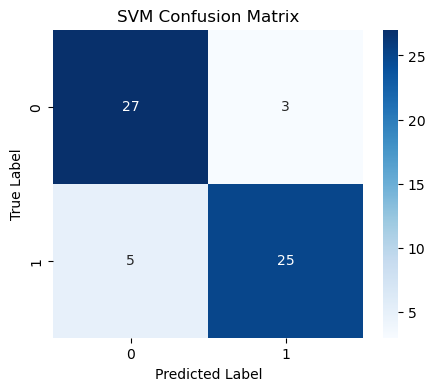

Identifying SVM Misclassified Samples
SVM Misclassified Sample Indices: [ 3 23 26 30 40 44 46 54]


Evaluating Neural Network Model
Extracting True Labels from Test Generator
Generating Predictions from Neural Network
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002749E2E7F60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━

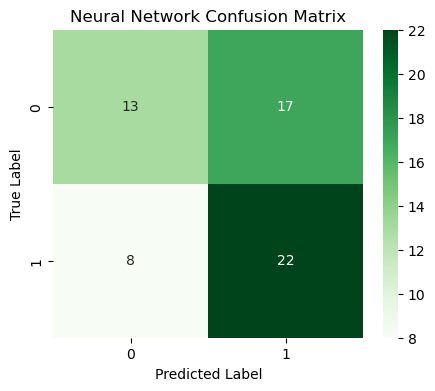

Identifying Neural Network Misclassified Samples
Neural Network Misclassified Sample Indices: [ 0  1  4  5  6  9 10 11 13 14 16 17 20 22 25 27 28 34 38 39 46 51 52 55
 58]


Comparing Model Performance
Calculating SVM Metrics
Calculating Neural Network Metrics
Printing SVM Performance Metrics
SVM Accuracy: 0.87
SVM Precision: 0.89
SVM Recall: 0.83
SVM F1-Score: 0.86


Printing Neural Network Performance Metrics
Neural Network Accuracy: 0.58
Neural Network Precision: 0.56
Neural Network Recall: 0.73
Neural Network F1-Score: 0.64

Analyzing Misclassifications
SVM misclassified 8 out of 60 samples.
Neural Network misclassified 25 out of 60 samples.
Extracting Misclassified Sample Details

SVM Misclassified Feature Details:
    brightness   sharpness  edge_density  lbp_mean   lbp_std  glcm_contrast  \
3   128.993593  517.166254      0.048594  5.271350  2.164420     400.537815   
23  133.788381  221.821694      0.047112  5.657270  2.184291     242.589934   
26  135.480733  342.552660      0

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Evaluating the SVM Model
print("Evaluating SVM Model")

# Generating classification report for the SVM model
print("Generating SVM Classification Report")
svm_report = classification_report(y_test, y_pred)
print(svm_report)

# Generating and printing the confusion matrix for SVM
print("Generating SVM Confusion Matrix")
svm_cm = confusion_matrix(y_test, y_pred)
print(svm_cm)

# Plotting the confusion matrix for SVM
print("Plotting SVM Confusion Matrix")
plt.figure(figsize=(5, 4))
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Identifying misclassified samples in the SVM model
print("Identifying SVM Misclassified Samples")
svm_misclassified = np.where(y_pred != y_test)[0]
print("SVM Misclassified Sample Indices:", svm_misclassified)
print("\n")

# Evaluating the Neural Network Model
print("Evaluating Neural Network Model")

# Extracting actual test labels from the test generator
print("Extracting True Labels from Test Generator")
y_test_nn = test_generator.classes

# Making predictions using the trained neural network model
print("Generating Predictions from Neural Network")
y_pred_nn_prob = model.predict(test_generator)

# Converting predicted probabilities into binary class labels
print("Converting Probabilities to Class Labels")
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()

# Generating classification report for the neural network model
print("Generating Neural Network Classification Report")
nn_report = classification_report(y_test_nn, y_pred_nn)
print(nn_report)

# Generating and printing the confusion matrix for the neural network
print("Generating Neural Network Confusion Matrix")
nn_cm = confusion_matrix(y_test_nn, y_pred_nn)
print(nn_cm)

# Plotting the confusion matrix for the neural network
print("Plotting Neural Network Confusion Matrix")
plt.figure(figsize=(5, 4))
sns.heatmap(nn_cm, annot=True, fmt="d", cmap="Greens")
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Identifying misclassified samples in the neural network model
print("Identifying Neural Network Misclassified Samples")
nn_misclassified = np.where(y_pred_nn != y_test_nn)[0]
print("Neural Network Misclassified Sample Indices:", nn_misclassified)
print("\n")

# Comparing Model Performance
print("Comparing Model Performance")

# Computing evaluation metrics for the SVM model
print("Calculating SVM Metrics")
svm_accuracy = accuracy_score(y_test, y_pred)
svm_precision = precision_score(y_test, y_pred)
svm_recall = recall_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred)

# Computing evaluation metrics for the neural network model
print("Calculating Neural Network Metrics")
nn_accuracy = accuracy_score(y_test_nn, y_pred_nn)
nn_precision = precision_score(y_test_nn, y_pred_nn)
nn_recall = recall_score(y_test_nn, y_pred_nn)
nn_f1 = f1_score(y_test_nn, y_pred_nn)

# Printing SVM performance metrics
print("Printing SVM Performance Metrics")
print("SVM Accuracy: {:.2f}".format(svm_accuracy))
print("SVM Precision: {:.2f}".format(svm_precision))
print("SVM Recall: {:.2f}".format(svm_recall))
print("SVM F1-Score: {:.2f}".format(svm_f1))
print("\n")

# Printing Neural Network performance metrics
print("Printing Neural Network Performance Metrics")
print("Neural Network Accuracy: {:.2f}".format(nn_accuracy))
print("Neural Network Precision: {:.2f}".format(nn_precision))
print("Neural Network Recall: {:.2f}".format(nn_recall))
print("Neural Network F1-Score: {:.2f}".format(nn_f1))

# Analyzing Misclassifications
print("\nAnalyzing Misclassifications")

# Printing the number of misclassified samples for each model
print("SVM misclassified {} out of {} samples.".format(len(svm_misclassified), len(y_test)))
print("Neural Network misclassified {} out of {} samples.".format(len(nn_misclassified), len(y_test_nn)))

# Extracting misclassified sample details from the dataset
print("Extracting Misclassified Sample Details")
misclassified_df_svm = df_features.iloc[svm_misclassified]
misclassified_df_nn = df_features.iloc[nn_misclassified]

# Printing details of misclassified samples for SVM
print("\nSVM Misclassified Feature Details:")
print(misclassified_df_svm)

# Printing details of misclassified samples for Neural Network
print("\nNeural Network Misclassified Feature Details:")
print(misclassified_df_nn)
